In [62]:
#импорт необходимых библиотек
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import norm,t

In [8]:
#чтение данных
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## Предобработка и первичный анализ данных

In [9]:
#исследование структуры данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [10]:
print('В датасете {} пропущенных данных'.format(data.isnull().sum().sum()))

В датасете 0 пропущенных данных


In [11]:
#преобразование столбцов к необходимым типам данных.
data['date'] = pd.to_datetime(data['date'])

In [12]:
print('Дата начала и дата окончания для теста для группы А')
print(data[data['group'] == 'A']['date'].agg(['min','max']))
print()
print('Дата начала и дата окончания для теста для группы В')
print(data[data['group'] == 'B']['date'].agg(['min','max']))

Дата начала и дата окончания для теста для группы А
min   2021-01-02
max   2021-01-24
Name: date, dtype: datetime64[ns]

Дата начала и дата окончания для теста для группы В
min   2021-01-02
max   2021-01-24
Name: date, dtype: datetime64[ns]


**Даты начала и окончания теста для двух групп одинаково**

In [13]:
print(data[data['group'] == 'A']['date'].max() - data[data['group'] == 'A']['date'].min())
print(data[data['group'] == 'B']['date'].max() - data[data['group'] == 'B']['date'].min())

22 days 00:00:00
22 days 00:00:00


**Длительность проведения теста для обоих групп одинаково**

In [14]:
#проверка: есть ли пользователи, которые в процессе A/B-теста попали в обе группы
group_a = set(list(data[data['group'] == 'A']['user_id']))
group_b = set(list(data[data['group'] == 'B']['user_id']))
both_groups = group_a.intersection(group_b)
print('Количество пользователей попавшие в обе группы составляет {}'.format(len(both_groups)))

Количество пользователей попавшие в обе группы составляет 1895


In [15]:
#Удалим записи с пользователями, попавшими в две группы
data.drop(index = data[data['user_id'].isin(both_groups)].index,inplace=True)

## Первичный анализ результатов A/B-тестирования

In [16]:
#Рассчитайте вспомогательные показатели для контрольной и тестовой групп
table = data.groupby('group').agg({'purchase':['count','sum'],'price':'sum'}).reset_index()
table.columns = ['group','purchase_count','purchase_sum','sum_price']
table

,group,purchase_count,purchase_sum,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


In [17]:
print('Разница в количестве посещений страниц между группами составляет {}'.format(table['purchase_count'].diff().dropna().iloc[0]))
print('Разница в суммарном количестве совершённых покупок составляет {}'.format(abs(table['purchase_sum'].diff().dropna().iloc[0])))
print('Разница в сумме всех покупок составляет {:,} рублей'.format(table['sum_price'].diff().dropna().iloc[0]))

Разница в количестве посещений страниц между группами составляет 74.0
Разница в суммарном количестве совершённых покупок составляет 197.0
Разница в сумме всех покупок составляет 115,230,000.0 рублей


**В ходе анализа вспомоготательных показателей контрольной и тестовой групп можно заметить, что разница в посещениях посадачной страницы не большая (группа B опережает группу A на 74 раза), в количестве покупок группа А опережает почти на 200 раз группу B, однако судя по сумме покупок, в группе B склонны покупать дорогие туры. По количеству посещений обоих вариантов посадочной страницы, ситуация почти ровнозначная, критической разницы нет.** 

In [18]:
#рассчет конверсии и среднего чека в группах 
table['conversion'] = (table['purchase_sum'] / table['purchase_count'])*100
table['average check'] = table['sum_price'] / table['purchase_sum']
table


,group,purchase_count,purchase_sum,sum_price,conversion,average check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


**По конверсии группа А чуть-чуть опережает группу В, а вот по среднему чеку группа В опережает, также не намного на чуть более 7 тыс. руб. группу А**

In [19]:
#сводная таблица зависимости количества продаж от группы и цены тура
pivot = pd.pivot_table(data = data, index='price',columns='group',values='purchase',aggfunc='sum')


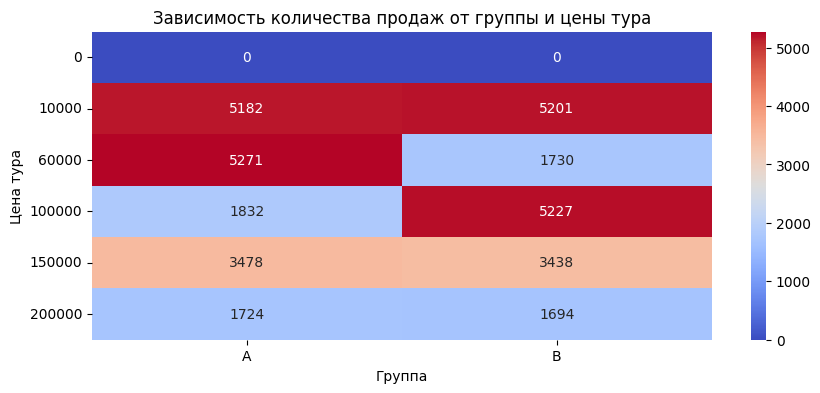

In [20]:
#Визуализация сводной таблицы
plt.figure(figsize=(10,4))
sns.heatmap(pivot,annot=True,fmt=".0f",cmap='coolwarm')
plt.title('Зависимость количества продаж от группы и цены тура')
plt.xlabel('Группа')
plt.ylabel('Цена тура')
plt.show()

**По сводной таблице можно сделать вывод, что во всех ценовых категориях ситуация примерно одинаковая, за исключением того, что в группе А склонны покупать туры в Турцию (60000 руб), гораздо больше, чем в группе Б, а вот в группе В, гораздо больше покупают туры за  100000 руб , то есть в Таиланд, поэтому и образовалась такая разница по сумме покупок между группами.**

## Анализ данных на предмет стабилизации метрик

In [21]:
#группировка данных по дате и группе тестирования
conv_data = data.groupby(['date','group']).agg({'purchase':['count','sum'],'price':'sum'}).reset_index()
conv_data.columns = ['date','group','purchase_count','purchase_sum','price']

#Добавление информации о ежедневной конверсии
conv_data['conversion'] = conv_data['purchase_sum'] / conv_data['purchase_count']

#Добавление информации о ежедневном среднем чеке
conv_data['average_check'] = conv_data['price']/conv_data['purchase_sum']

#добавляем кумулятивное количество посещений страницы
conv_data['purchase_count_cum'] = conv_data['purchase_count'].cumsum()

#добавляем кумулятивное количество покупок
conv_data['purchase_sum_cum'] = conv_data['purchase_sum'].cumsum()

#добавляем кумулятивную сумму покупок
conv_data['price_cum'] = conv_data['price'].cumsum()

#кумулятивная конверсия
conv_data['cum_conversion'] = conv_data['purchase_sum_cum'] / conv_data['purchase_count_cum']

#кумулятивный средний чек
conv_data['cum_average_check'] = conv_data['price_cum'] / conv_data['purchase_sum_cum']


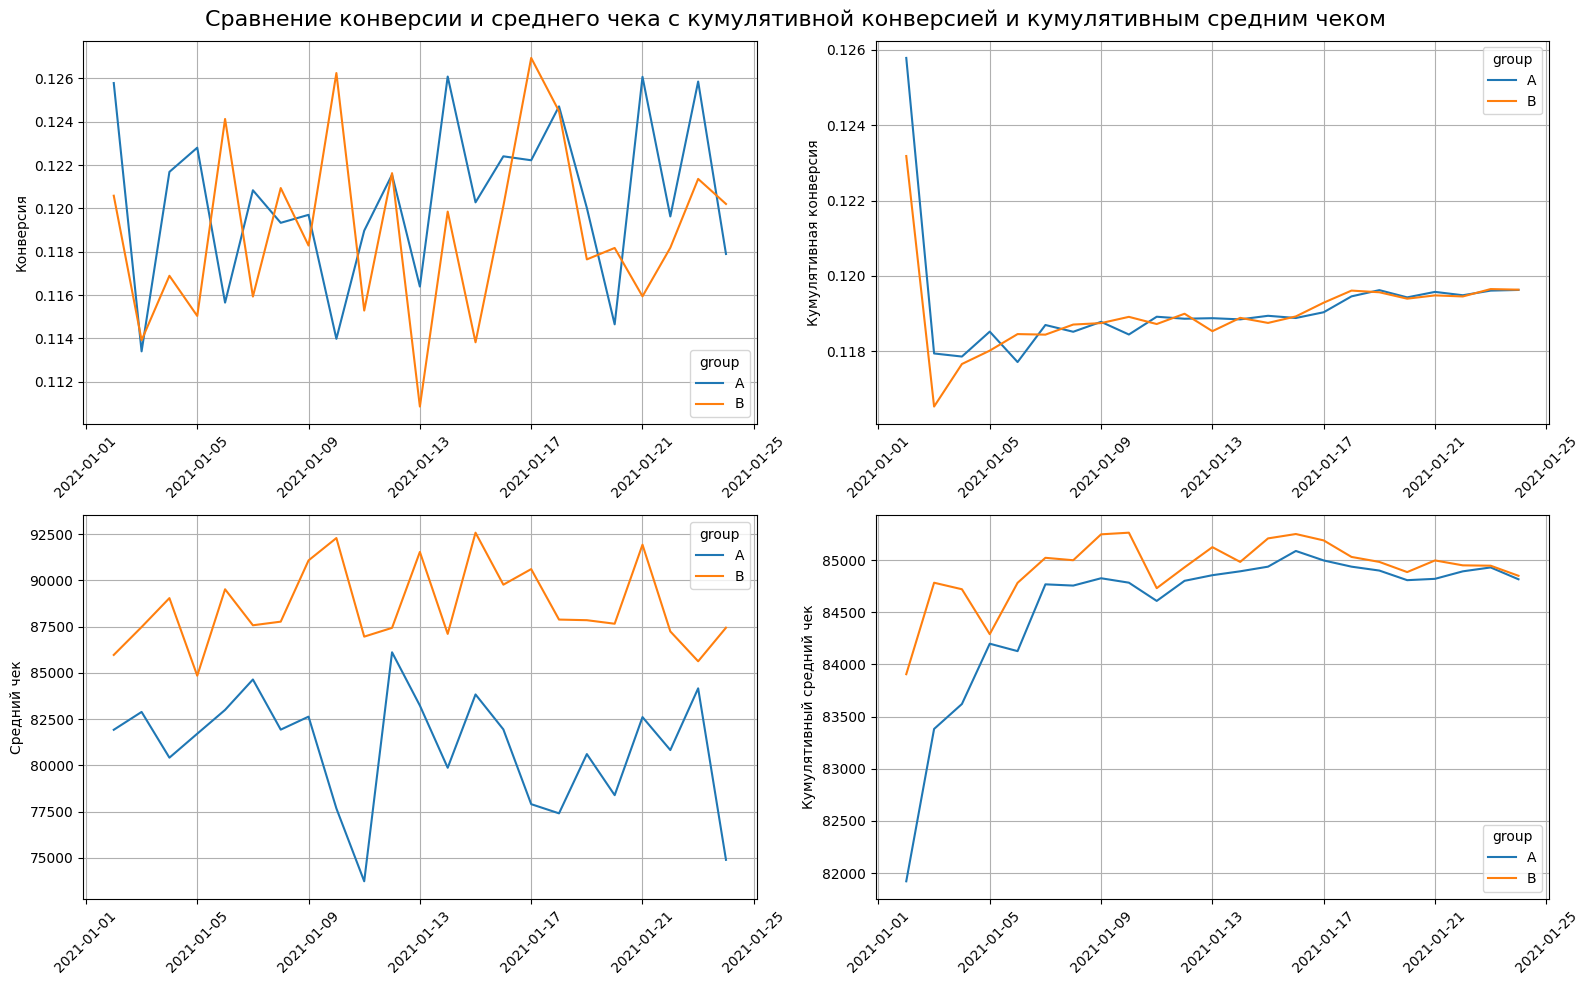

In [22]:
#построение кумулятивных графиков конверсии и среднего чека в каждой группе по дням.
fig,axes = plt.subplots(figsize=(16,10),nrows=2,ncols=2)
plt.suptitle('Сравнение конверсии и среднего чека с кумулятивной конверсией и кумулятивным средним чеком',fontsize=16)


sns.lineplot(data=conv_data,x='date',y='conversion',hue='group',ax=axes[0,0])
axes[0,0].xaxis.set_tick_params(rotation=45)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Конверсия')
axes[0,0].grid(True)
sns.lineplot(data=conv_data,x='date',y='cum_conversion',hue='group',ax=axes[0,1])
axes[0,1].set_ylabel('Кумулятивная конверсия')
axes[0,1].set_xlabel('')
axes[0,1].grid(True)
axes[0,1].xaxis.set_tick_params(rotation=45)
sns.lineplot(data=conv_data,x='date',y='average_check',hue='group',ax=axes[1,0])
axes[1,0].set_ylabel('Средний чек')
axes[1,0].set_xlabel('')
axes[1,0].grid(True)
axes[1,0].xaxis.set_tick_params(rotation=45)
sns.lineplot(data=conv_data,x='date',y='cum_average_check',hue='group',ax=axes[1,1])
axes[1,1].set_ylabel('Кумулятивный средний чек')
axes[1,1].set_xlabel('')
axes[1,1].xaxis.set_tick_params(rotation=45)
axes[1,1].grid(True)
plt.tight_layout()
plt.show()

**При сравнении конверсии и среднего чека с кумулятивными конверсией и средним чеком, можно сказать, что при кумулятивных показателях резкие скачки наблюдаются лишь в начале, далее они стабилизируются и линии переходят в прямые. Однако сказать, какая группа является лучшей, не получится, поскольку разница между ними наблюдается только в начале, далее они все равно стремятся друг к другу и пересекаются друг с другом. А/Б тест не завершен**

## Статистический анализ результатов A/B-тестирования

In [23]:
#подготовим данные для проведения z-теста для сравнения конверсии в двух группах 
converted_piv = data.groupby('group')['purchase'].agg(['count','sum'])

Нулевая гипотеза: конверсии в группах A и B равны. 

$H_0:p_a = p_b$

Альтернативная: конверсии в группах A и B не равны.

$H_1:p_a \neq p_b$ 

Зададим уровень значимости $\alpha=0.05$ и будем сравнивать полученное p-value с ним.

In [24]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


**Тест показал, что разницы между вариантами посадочной страницы официального сайта нет — они одинаково эффективны по метрике конверсии.Можно также проверить, является ли вариант А посадочной страницы лучше варианта B,и поместить это в альтернативную гипотезу**

Нулевая: конверсия в группе А меньше либо равна конверсии в группе B.

$H_0:p_a \leq p_b$

Альтернативная: конверсия в группе А больше, чем конверсия в группе B.

$H_1:p_a > p_b$

In [25]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.12
У нас нет оснований отвергнуть нулевую гипотезу


**В обоих вариантах проведения z-теста p_value больше alpha, а значит, можно сделать вывод о том, что статистической разницы между конверсиями в группах А и В не имеется.Теперь сравним ежедневные средние чеки двух групп**

In [57]:
#сравниваем значения средних и медиан средних чеков обоих групп
conv_data.groupby('group')['average_check'].agg(['mean','median'])

,mean,median
group,,
A,80969.285099,81922.005571
B,88575.715514,87770.935961


**Предварительно можно сделать вывод, о том, что среднее и медиана тестовой группы В, выше чем в контрольной группы А**

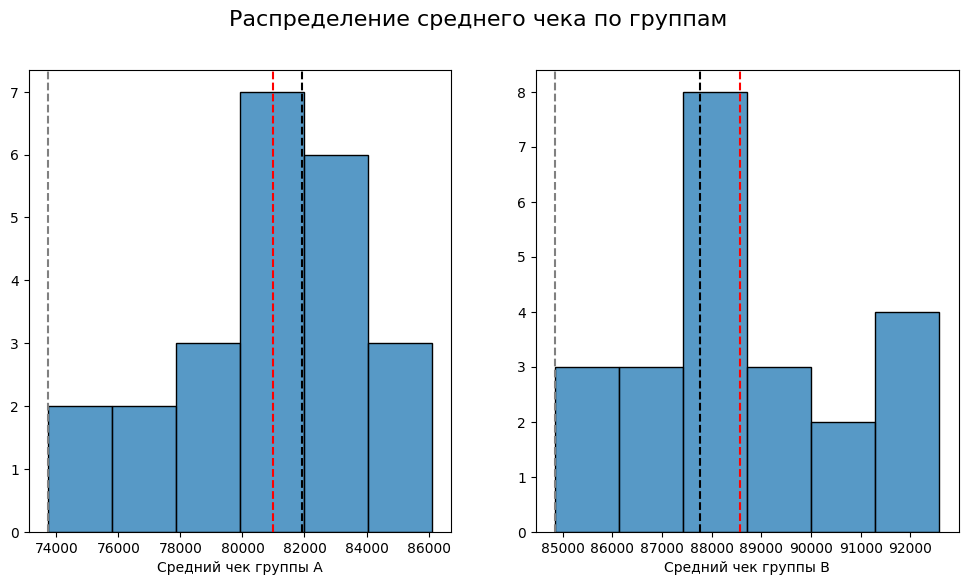

In [45]:
#Посмотрим на нормальность распределения среднего чека 
group_a = conv_data[conv_data['group']=='A']
group_b = conv_data[conv_data['group']=='B']

fig,axes = plt.subplots(1,2, figsize=(12,6))
plt.suptitle('Распределение среднего чека по группам',fontsize=16)
sns.histplot(data=group_a,x='average_check',ax=axes[0])
axes[0].axvline(group_a['average_check'].mean(),color='red',linestyle='--')
axes[0].axvline(group_a['average_check'].median(),color='black',linestyle='--')
axes[0].axvline(group_a['average_check'].mode()[0],color='grey',linestyle='--')
axes[0].set_xlabel('Средний чек группы А')
axes[0].set_ylabel('')

sns.histplot(data=group_b,x='average_check',ax=axes[1])
axes[1].axvline(group_b['average_check'].mean(),color='red',linestyle='--')
axes[1].axvline(group_b['average_check'].median(),color='black',linestyle='--')
axes[1].axvline(group_b['average_check'].mode()[0],color='grey',linestyle='--')
axes[1].set_xlabel('Средний чек группы B')
axes[1].set_ylabel('')

plt.show()

**Поскольку на графике медиана, среднее и мода находятся не в одной точке, данные нельзя назвать нормально распределенными, но все же необходимо дополнительно воспользоваться статистическим тестом, например теста Д’Агостино,при этом также зададим уровень значимости alpha=0.05**

In [ ]:
#Проведем тест Д’Агостино. Нулевая гипотеза: данные распределены нормально. Альтернативная: данные не распределены нормально
alpha = 0.05 # уровень значимости
_, a_p_value = normaltest(group_a['average_check'])
_,b_p_value = normaltest(group_b['average_check'])

print('p_value группы А составляет {:.3f}'.format(a_p_value))
print('p_value группы B составляет {:.3f}'.format(b_p_value))

# сравниваем полученное p-value для группы А с уровнем значимости
if a_p_value < alpha:
    print('Есть основание отвергнуть нулевую гипотезу о нормальности распределения группы А')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том что данные группы А распределены нормально')

# сравниваем полученное p-value для группы B с уровнем значимости    
if b_p_value < alpha:
    print('Есть основание отвергнуть нулевую гипотезу о нормальности распределения группы B')
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том что данные группы B распределены нормально')

p_value группы А составляет 0.249
p_value группы B составляет 0.422
Нет оснований отвергнуть нулевую гипотезу о том что данные группы А распределены нормально
Нет оснований отвергнуть нулевую гипотезу о том что данные группы B распределены нормально


**Однако, статистический тест показал, что данные распределены нормально, в связи с этим необходимо воспользоваться параметрическим тестом, например Т-тестом**

Нулевая гипотеза: среднее ежедневного среднего чека посадочной страницы сайта, на которой проводят пользователи из группы из контрольной группы А, равно среднему ежедневному среднему чеку варианта посадочной страницы сайта, на которой проводят время пользователи из  тестовой группы B:

$H_0:\mu_a=\mu_b$

Альтернативная гипотеза: среднее ежедневного среднего чека посадочной страницы сайта, на которой проводят пользователи из группы из контрольной группы А, отличается от ежедневного среднего чека варианта посадочной страницы сайта, на которой проводят время пользователи из  тестовой группы B:

$H_1:\mu_a \neq \mu_b$

In [55]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=group_a['average_check'],
    b=group_b['average_check'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")


p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


**Таким образом статистически подтвеждается, т.е. существует разница между средними чеками контрольной и тестовой групп, у  группы B средний чек выше. Результаты статистических тестов, также можно подкрепить, построив 95% доверительные интервалы**

In [ ]:
#напишем функцию  возвращающую границы 95 % интервала для разных групп
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=data[data['group']=='A']['purchase'].mean(), # выборочная пропорция
    n=data[data['group']=='A']['user_id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=data[data['group']=='B']['purchase'].mean(), # выборочная пропорция
    n=data[data['group']=='B']['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (np.float64(11.87), np.float64(12.2))
Доверительный интервал для конверсии в группе B: (np.float64(11.73), np.float64(12.06))


**Можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.2 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %,т.е.есть перекрытие между доверительными интервалами для групп, это означает, что истинное значение конверсии в обеих группах может совпасть. Чтобы с уверенностью сказать, есть ли разница в конверсиях,нужно построить доверительный интервал разницы пропорций.**

In [61]:
#напишем функцию  возвращающую границы 95 % интервала для
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

# размеры выборок групп А и B
n = [data[data['group']=='A']['user_id'].count(), data[data['group']=='B']['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [data[data['group']=='A']['purchase'].mean(), data[data['group']=='B']['purchase'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (np.float64(-0.38), np.float64(0.09))


**Поскольку левая граница доверительного интервала отрицательная, а правая — положительная, то есть истинная разница в конверсии  может быть как положительной, так и отрицательной. Тогда это будет значить, что варианты А и B равнозначны по метрике конверсии. Построим также 95% интервал для средних чеков двух групп**

In [66]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    k = n-1
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# cтроим доверительный интервал для среднего при неизвестном СКО
A_lower_bound, A_upper_bound = t_mean_conf_interval(group_a['average_check'].mean(), group_a['average_check'].std(), group_a['average_check'].shape[0])
B_lower_bound, B_upper_bound = t_mean_conf_interval(group_b['average_check'].mean(), group_b['average_check'].std(), group_b['average_check'].shape[0])
# выводим результат
print('Доверительный интервал для группы А: {}'.format((round(A_lower_bound), round(A_upper_bound))))
print('Доверительный интервал для группы Б: {}'.format((round(B_lower_bound), round(B_upper_bound))))

Доверительный интервал для группы А: (79630, 82308)
Доверительный интервал для группы Б: (87626, 89526)


**Как можно заметить построение доверительного интервала для среднего чеков двух групп, подверждает результаты проведенных статитистических тестов, а именно ежедневный средний чек группы В выше чем средний чек группы А** 

## Общий вывод по результатам A/B-теста

**По метрикам конверсии оба варианта посадочной страницы равнозначны, что подверждается статистическими тестами, а также построением 95% доверительного интервала. В ходе различных способов анализа ежедневного среднего чека двух групп, установлено, что, группа В выглядит более выигрышно, за счет того, что пользователи этой группы покупают более дорогие туры (Тайланд). Следовательно вариан В дизайна посадочной страницы сайта турагентства более предпочтителен**